Decoded barcode: ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']


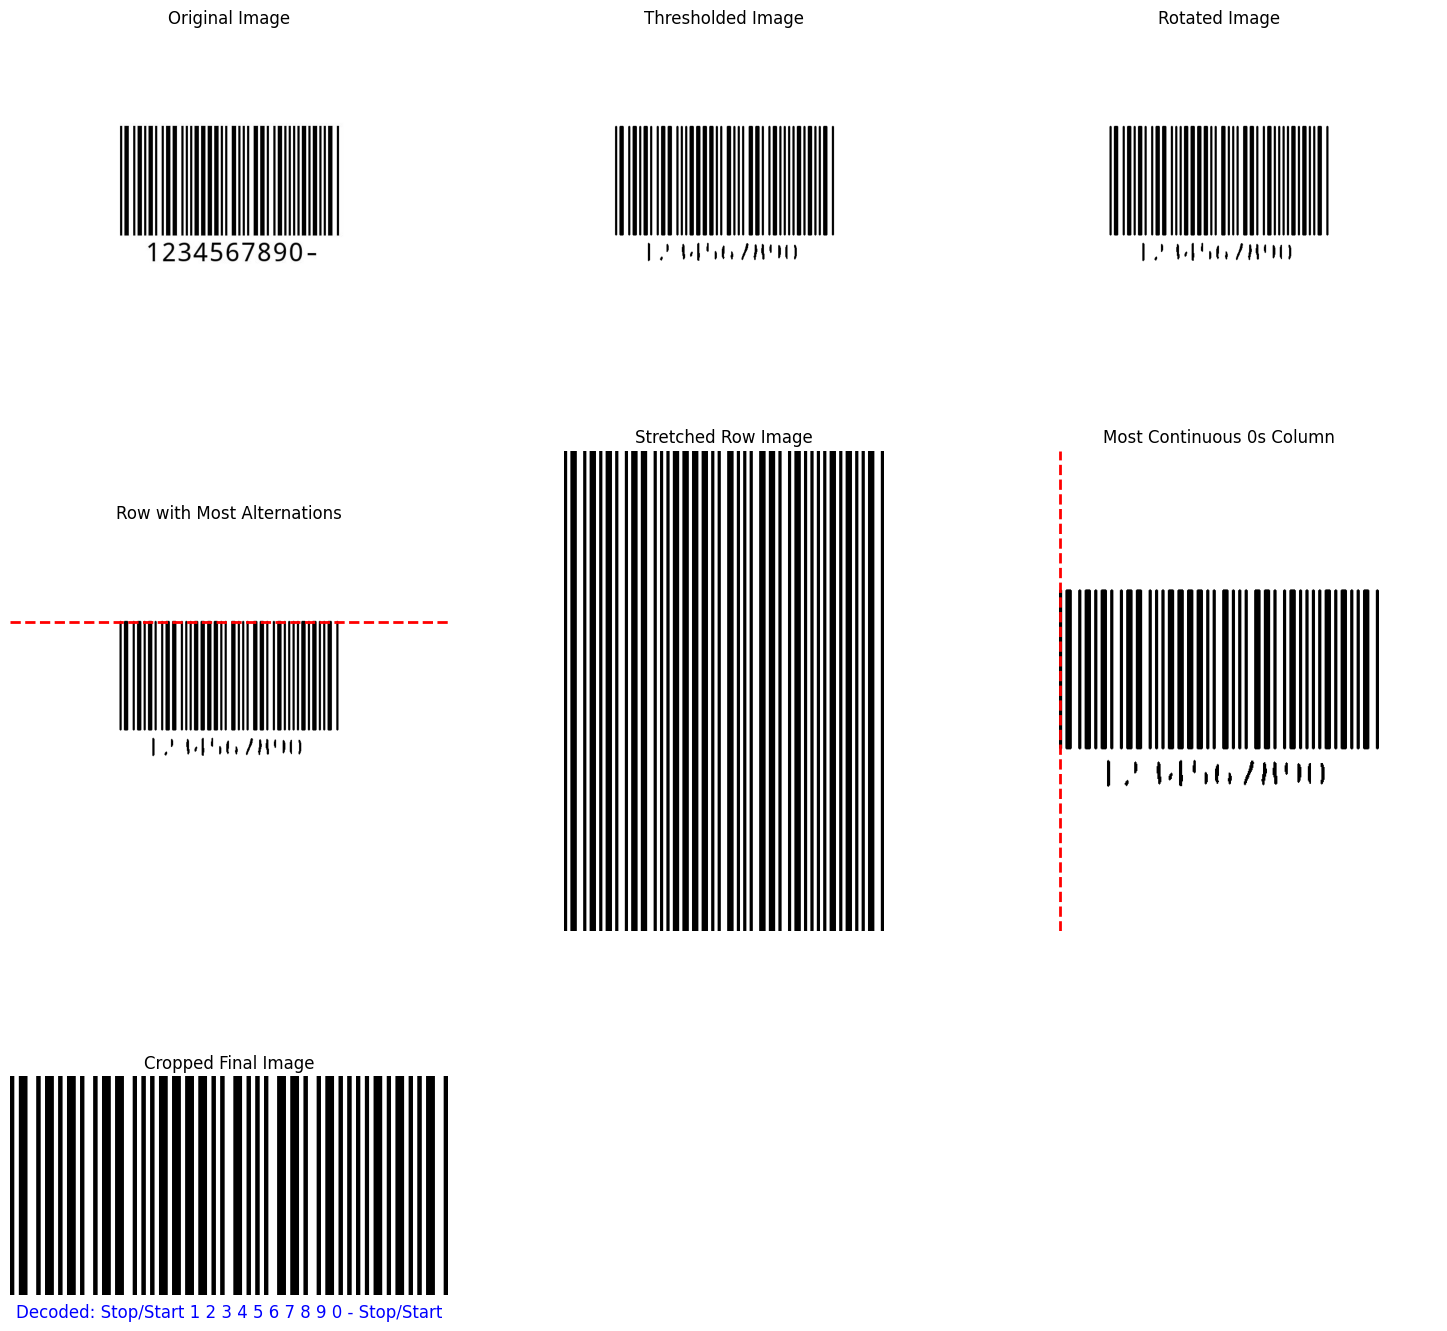

In [206]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#---------------------------MyLastEffort-----------------------------#
#-------------------- Barcode Decoding Constants --------------------#
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1", "01001": "2", "11000": "3", "00101": "4", "10100": "5",
    "01100": "6", "00011": "7", "10010": "8", "10000": "9", "00001": "0",
    "00100": "-"
}

#-------------------- Utility Functions --------------------#
def count_black_pixels(row):
    """
    Counts the number of black pixels (0 value) in a given row.
    :param row: Array representing a single row of pixel data.
    :return: Count of black pixels.
    """
    return np.count_nonzero(row == 0)

def find_best_row_with_most_black_pixels(image):
    """
    Analyzes each row to find the one with maximum black pixels.
    Returns row index, row data, and count of black pixels.
    """
    max_black_pixels = 0
    best_row_index = None
    best_row_data = None

    for row_idx in range(image.shape[0]):
        row = image[row_idx, :]
        black_pixel_count = count_black_pixels(row)

        if black_pixel_count > max_black_pixels:
            max_black_pixels = black_pixel_count
            best_row_index = row_idx
            best_row_data = row

    return best_row_index, best_row_data, max_black_pixels

def find_best_zero_column(image):
    """
    Finds the column with the longest continuous sequence of black pixels (zeros).
    Returns column index and height of the continuous sequence.
    """
    def count_continuous_zeros_in_column(col_idx):
        max_continuous = 0
        current_streak = 0
        counting = False

        for row in range(image.shape[0]):
            if image[row, col_idx] == 0:  # Black pixel
                current_streak += 1
                counting = True
            else:  # White pixel
                if counting:
                    max_continuous = max(max_continuous, current_streak)
                    current_streak = 0
                    counting = False

        # Check final streak
        if counting:
            max_continuous = max(max_continuous, current_streak)

        return max_continuous

    max_zero_height = 0
    best_zero_column = 0

    for col in range(image.shape[1]):
        continuous_zero_count = count_continuous_zeros_in_column(col)
        if continuous_zero_count > max_zero_height:
            max_zero_height = continuous_zero_count
            best_zero_column = col

    return best_zero_column, max_zero_height

#-------------------- Barcode Decoding Functions --------------------#
def decode_barcode(cropped_image):
    """
    Decodes Code-11 barcode from a cropped image.
    Returns list of decoded digits/characters.
    """
    mean = cropped_image.mean(axis=0)
    mean[mean <= 127] = 1
    mean[mean > 128] = 0
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2
    digits, pixel_index, current_digit_widths, skip_next = [], 0, "", False

    while pixel_index < len(pixels):
        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE
        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    return digits

def try_decode(image):
    """
    Attempts to decode barcode from image, returns None if unsuccessful.
    """
    try:
        digits = decode_barcode(image)
        return digits
    except Exception:
        pass
    return None

#-------------------- Image Processing Functions --------------------#
def removeColored(image):
    """
    Converts colored pixels to white and keeps grayscale pixels unchanged.
    Used for removing noise and colored artifacts.
    """
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            r, g, b = image[y, x]
            if r != g or g != b:
                image[y, x] = [255, 255, 255]
            else:
                gray = r
                image[y, x] = [gray, gray, gray]

    return image

def sharpen_image(image):
    """
    Adaptive image sharpening based on image quality:
    - For low/high sharpness: Uses median filtering
    - For medium sharpness: Applies custom sharpening kernel
    """
    sharpness = cv2.Laplacian(image, cv2.CV_64F).var()


    if sharpness > 250 or sharpness < 50:

        medianfilter = cv2.medianBlur(cv2.blur(image, (1, 13)), 3)
        medianfilter = cv2.medianBlur(cv2.blur(medianfilter, (1, 13)), 3)
        _, sharpened = cv2.threshold(medianfilter, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        pwr = np.log(sharpness + 1)

        kernel = np.array([
            [0, -1   , 0],
            [-1, pwr , -1],
            [0, -1   , 0]
        ]) / pwr

        # Apply the kernel
        img_sharp = cv2.filter2D(image, -1, kernel)
        _, sharpened = cv2.threshold(img_sharp, 128, 255, cv2.THRESH_BINARY)

    return sharpened

def detect_wave_noise(image):
    """
    Detects and removes wave patterns using FFT transformation.
    Falls back to adaptive thresholding if no significant wave patterns found.
    """
    fftTransform = np.fft.fftshift(np.fft.fft2(image))
    magnitudeSpectrum = np.abs(fftTransform)
    waveThreshold = np.mean(magnitudeSpectrum) * 1.5
    magnitudeSpectrum[magnitudeSpectrum < waveThreshold] = 0

    peaks = np.where(magnitudeSpectrum > np.max(magnitudeSpectrum) * 0.1)
    if len(peaks[0]) < 2:
        return image
    return cv2.adaptiveThreshold(
            image, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 15, 2
        )

def makehorizontal(image):
    """
    Rotates the image to horizontal orientation:
    1. Detects edges using Sobel
    2. Finds main contour
    3. Calculates rotation angle
    4. Applies affine transformation
    """
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = cv2.magnitude(x, y)
    magnitude = np.uint8(np.clip(magnitude, 0, 255))

    _, edges = cv2.threshold(magnitude, 50, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image

    contour = max(contours, key=cv2.contourArea)

    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    angle = rect[-1]


    if angle < -45:
        angle += 90

    (height, width) = image.shape[:2]
    center = (width // 2, height // 2)

    rotMatrix = cv2.getRotationMatrix2D(center, angle, 1.0)


    cos = np.abs(rotMatrix[0, 0])
    sin = np.abs(rotMatrix[0, 1])
    width, height = int(height * sin + width * cos), int(height * cos + width * sin)

    rotMatrix[0, 2] += (width / 2) - center[0]
    rotMatrix[1, 2] += (height / 2) - center[1]


    img_rotated = cv2.warpAffine(image, rotMatrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    if width < height:
        img_rotated = cv2.rotate(img_rotated, cv2.ROTATE_90_CLOCKWISE)


    return img_rotated

#-------------------- Main Execution Flow --------------------#
# Load and preprocess image
image_path = "1.jpg"
orimage = cv2.imread(image_path)

# Initial image processing pipeline
image = removeColored(orimage)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = detect_wave_noise(image)
image = sharpen_image(image)

# Enhance contrast and apply thresholding
contrast_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
_, thresholded_image = cv2.threshold(contrast_image, 128, 255, cv2.THRESH_BINARY)

# Rotate and analyze image
rotated = makehorizontal(thresholded_image)
best_row_index, best_row, max_black_pixels = find_best_row_with_most_black_pixels(rotated)

# Process image dimensions
(h, w) = image.shape[:2]
stretched_section = np.tile(best_row, (h, 1))

# Find barcode boundaries
non_zero_cols = np.where(stretched_section != 255)[1]
left, right = non_zero_cols.min(), non_zero_cols.max()

# Find optimal column for cropping
best_zero_column, max_zero_height = find_best_zero_column(rotated)
cropped_image = stretched_section[:max_zero_height, left:right+1]

# Add barcode decoding attempt after cropping
decoded_result = try_decode(cropped_image)
if decoded_result:
    print("Decoded barcode:", decoded_result)
else:
    print("Failed to decode barcode")

#-------------------- Visualization --------------------#
# Create figure with 3x3 subplots
plt.figure(figsize=(15, 15))

# Original Image
plt.subplot(331)
plt.title("Original Image")
plt.imshow(orimage, cmap='gray')
plt.axis('off')

# Thresholded Image
plt.subplot(332)
plt.title("Thresholded Image")
plt.imshow(thresholded_image, cmap='gray')
plt.axis('off')

# Rotated Image
plt.subplot(333)
plt.title("Rotated Image")
plt.imshow(rotated, cmap='gray')
plt.axis('off')

# Rotated Image with Row Highlight
plt.subplot(334)
plt.title("Row with Most Alternations")
plt.imshow(rotated, cmap='gray')
plt.axhline(y=best_row_index, color='red', linestyle='--', linewidth=2)
plt.axis('off')

# Stretched Row Image
plt.subplot(335)
plt.title("Stretched Row Image")
plt.imshow(stretched_section[:, left:right+1], cmap='gray')
plt.axis('off')

# Image with Column Highlight
plt.subplot(336)
plt.title("Most Continuous 0s Column")
plt.imshow(rotated[:,left:right+1], cmap='gray')
plt.axvline(x=best_zero_column - left, color='red', linestyle='--', linewidth=2)
plt.axis('off')

# Cropped Final Image with Decoded Result
plt.subplot(337)
plt.title("Cropped Final Image")
plt.imshow(cropped_image, cmap='gray')
plt.axis('off')

# Add decoded result as text below the image
if decoded_result:
    result_text = f"Decoded: {' '.join(decoded_result)}"
else:
    result_text = "Decoding failed"
plt.text(0.5, -0.1, result_text,
         horizontalalignment='center',
         transform=plt.gca().transAxes,
         fontsize=12,
         color='blue')

# Adjust layout and display
plt.tight_layout()
plt.show()